Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9


Wrote a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, November 27
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [75]:
import numpy as np
import random
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

from utils.reproduce_functions import *
from utils.mutation_functions import *
from utils.parent_selection_functions import *
from utils.other_fucntions import *
from utils.island_functions import *

import lab9_lib

In [76]:
PROBLEM_SIZE = 2

MU = 10
LAMBDA = 20
strategy = 'plus' # comma or plus

MUTATION_PROB = 0.2
DYNAMIC_MUTATION_PROB = True
DIVERSITY_THRESHOLD = 20

SEGREGATION = True
COOLDOWN_TIME = 250
LENGTH_SOLUTION = 1000
NUMBER_GENERATIONS = 5000

NUM_ISLANDS = 10

In [77]:
# Function to perform swapping between islands
mutate = one_bit_flip
reproduce = uniform_crossover
parent_selection = roulette

when_to_swap = fitness_based
swap_individuals_between_islands = fitness_based_migration

In [78]:
def ga(fitness, islands, islands_evals, memoization=False, history=None):
    if memoization:
        pop_history = {}
        for i in range(len(islands_evals)):
            for j in range(len(islands_evals[i])):
                pop_history[islands[i][j].tobytes()] = islands_evals[i][j]
    
    cooldown = COOLDOWN_TIME
    for generation in tqdm(range(NUMBER_GENERATIONS)):
        for island_ix, island in enumerate(islands):
            parents = island
            parents_evals = islands_evals[island_ix]
            offsprings = []
            offsprings_evals = []

            while len(offsprings) < LAMBDA:
                
                p1, p2 = parent_selection(parents, parents_evals)
    
                # Reproduce Parents
                off_spring = reproduce(p1, p2)
                
               # Mutate Offspring
                if DYNAMIC_MUTATION_PROB:
                    p_div = get_parents_diversity(p1, p2)
                    new_ind1 = mutate(off_spring, \
                                    mutation_probability=(1 - (min(p_div,LENGTH_SOLUTION/2)/(LENGTH_SOLUTION/2))) )
                else:    
                    new_ind1 = mutate(off_spring, mutation_probability=MUTATION_PROB)

                # Evaluate Offspring
                if memoization:
                    new_ind1_eval = pop_history.get(new_ind1.tobytes())
                    if new_ind1_eval == None:
                        new_ind1_eval = fitness(new_ind1)
                        pop_history[new_ind1.tobytes()] = new_ind1_eval
                else:
                    new_ind1_eval = fitness(new_ind1)

                offsprings.append(new_ind1)

                offsprings_evals.append(new_ind1_eval)
                if memoization:
                    pop_history[new_ind1.tobytes()] = new_ind1_eval

            # Create new population (with parents if plus, without if comma)
            all_people = (parents if strategy=='plus' else []) + offsprings
            all_evals = (parents_evals if strategy=='plus' else []) + offsprings_evals
            best_people = np.argsort(all_evals)[::-1]

            parents = []
            parents_evals = []
            for i in range(MU):
                parents.append(all_people[best_people[i]])
                parents_evals.append(all_evals[best_people[i]])
            islands[island_ix] = parents
            islands_evals[island_ix] = parents_evals
            
            if np.max(parents_evals) - 1.0 >= 0:
                print(f"Early stopping {generation=}")
                return parents, parents_evals

            if history is not None:
                history[island_ix].append(np.max(parents_evals))


        if when_to_swap(islands_evals):
            swap_individuals_between_islands(islands, islands_evals)
            # swap_individuals_between_islands(islands)


        if history is not None and len(islands) > 1 and generation > cooldown:
            mean_fitnesses = []
            for island_ix, x in enumerate(islands_evals):
                mean_fitnesses.append(np.mean(x))

            mean_fitnesses = np.array(mean_fitnesses)
            mean_fitnesses = np.reshape(mean_fitnesses, (len(mean_fitnesses), 1))
            diff_mat = np.abs(mean_fitnesses - mean_fitnesses.transpose())

            for island_ix, island in enumerate(islands):
                if len(history[island_ix]) > COOLDOWN_TIME and \
                    (np.diff(history[island_ix])[-COOLDOWN_TIME:] < 0.002).all() and \
                    mean_fitnesses[island_ix] != max(mean_fitnesses):
                    
                    print("Num islands", len(islands)-1)
                    # Merge two islands
                    most_similar_island_idx = np.argsort(diff_mat[island_ix])[1] #0 is same island, diff=0

                    islands[most_similar_island_idx].extend(islands[island_ix])
                    islands_evals[most_similar_island_idx].extend(islands_evals[island_ix])

                    if SEGREGATION == True:
                        islands.pop(island_ix)
                        islands_evals.pop(island_ix)
                    else:
                        if memoization:
                            new_island = []
                            while len(new_island) < MU:
                                new_ind = np.random.randint(2, size=LENGTH_SOLUTION)
                                if pop_history.get(new_ind.tobytes()) != None:
                                    continue
                                
                                new_island.append(new_ind)
                                pop_history[new_ind.tobytes()] = fitness(new_ind)
                                

                            islands[island_ix] = new_island
                            islands_evals[island_ix] = [pop_history[ind.tobytes()] for ind in islands[island_ix]]
                        else:
                            islands[island_ix] = [np.random.randint(2, size=LENGTH_SOLUTION) for _ in range(MU)]
                            islands_evals[island_ix] = [fitness(ind) for ind in islands[island_ix]]
                    
                    cooldown = generation + COOLDOWN_TIME
                    break
                    

        # if when_to_swap(generation, 10):
        #     # swap_individuals_between_islands(islands, islands_evals)
        #     swap_individuals_between_islands(islands)

    return parents, parents_evals

Without memoization

  0%|          | 1/5000 [00:00<25:41,  3.24it/s]

  7%|▋         | 369/5000 [01:06<13:20,  5.78it/s]

Num islands 9


 12%|█▏        | 620/5000 [01:47<11:09,  6.54it/s]

Num islands 8


 17%|█▋        | 871/5000 [02:23<09:32,  7.21it/s]

Num islands 7


 22%|██▏       | 1122/5000 [02:55<07:54,  8.18it/s]

Num islands 6


 27%|██▋       | 1374/5000 [03:23<06:06,  9.90it/s]

Num islands 5


 32%|███▏      | 1624/5000 [03:45<04:50, 11.60it/s]

Num islands 4


 38%|███▊      | 1876/5000 [04:04<03:26, 15.12it/s]

Num islands 3


 43%|████▎     | 2129/5000 [04:20<02:28, 19.37it/s]

Num islands 2


 48%|████▊     | 2382/5000 [04:30<01:22, 31.84it/s]

Num islands 1


100%|██████████| 5000/5000 [05:24<00:00, 15.39it/s]


Best score:  0.49660000000000004
Num fitness calls:  347460


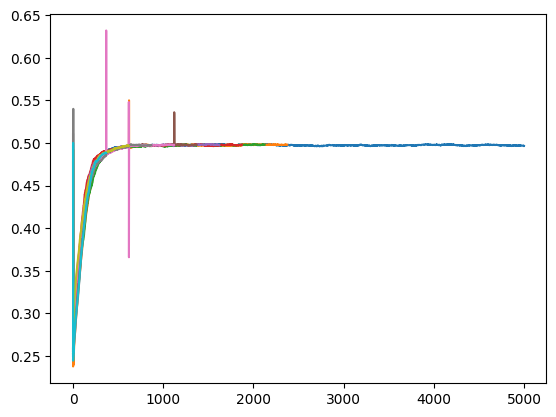

In [79]:
fitness = lab9_lib.make_problem(PROBLEM_SIZE)
islands = [ [generate_random_individual(length=LENGTH_SOLUTION) for _ in range(50) ] for _ in range(NUM_ISLANDS) ]
history = [[] for _ in range(NUM_ISLANDS)]

islands_evals = [[fitness(x) for x in island] for island in islands ]
parents, parents_evals = ga(fitness, islands, islands_evals, memoization=False, history=history)
i_best = np.argmax(parents_evals)

print("Best score: ", parents_evals[i_best])
print("Num fitness calls: ", fitness.calls)

for x in history:
    plt.plot(x)
plt.show()

With memoization

In [80]:
fitness = lab9_lib.make_problem(PROBLEM_SIZE)
islands = [ [generate_random_individual(length=LENGTH_SOLUTION) for _ in range(50) ] for _ in range(NUM_ISLANDS) ]
islands_evals = [[fitness(x) for x in island] for island in islands ]

history = [[] for _ in range(NUM_ISLANDS)]

parents, parents_evals = ga(fitness, islands, islands_evals, memoization=True, history=history)
i_best = np.argmax(parents_evals)

print("Best score: ", parents_evals[i_best])
print("Num fitness calls: ", fitness.calls)

for x in history:
    plt.plot(x)
plt.show()

  5%|▌         | 271/5000 [00:56<16:53,  4.67it/s]